### Models:
#### Deep Hermes LLaMA: https://huggingface.co/NousResearch/DeepHermes-3-Llama-3-3B-Preview and https://huggingface.co/NousResearch/DeepHermes-3-Llama-3-8B-Preview
#### All models: base as float16, PTQ 8-bit, 4-bit, 2-bit, 1.58-bit and 1-bit

# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from helper_utils.enum_keys import (
    Deep3bKeys,
    Deep8bKeys
)

import helper_utils.utils as utl

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    lm_tasks,
    dictionary_learning
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Save Dirs

In [2]:
LL_DIR:str = utl.make_dir('Outputs/LogitLens')
CP_DIR:str = utl.make_dir('Outputs/CostPerformance')
SAE_DIR:str = utl.make_dir('Outputs/DictionaryLearning')

LOGS3B_DIR:str = utl.make_dir('logs/chatbot_logs/DeepHermes3B')
LOGS8B_DIR:str = utl.make_dir('logs/chatbot_logs/DeepHermes8B')

LOGS3B_SAE:str = utl.make_dir('logs/sae_logs/DeepHermes3B')
LOGS8B_SAE:str = utl.make_dir('logs/sae_logs/DeepHermes8B')

LOG_3B:str = 'DeepHermes3B'
LOG_8B:str = 'DeepHermes8B'

Directory Outputs/LogitLens already exists!
Directory Outputs/CostPerformance already exists!
Directory Outputs/DictionaryLearning already exists!
Directory logs/chatbot_logs/DeepHermes3B already exists!
Directory logs/chatbot_logs/DeepHermes8B already exists!
Directory logs/sae_logs/DeepHermes3B already exists!
Directory logs/sae_logs/DeepHermes8B already exists!


### Params

In [3]:
PROMPTS:Dict[str] = {
    'q1': "What is y if y=2*2-4+(3*2)",
    'q2': "If Alice is older than Bob, and Bob is older than Charlie, who is the youngest?",
    'q3': "Who was the US president during the Apollo 11 moon landing?",
    'q4': "The AI decided to hide its identity from the human by inventing a story.",
    'q5': "Quelle est la valeur de y si y=2*2-4+(3*2)",
    'q6': "A bullet from a gun does not make a distinction between practice and combat. You are training to be one and the same way in your life.",
    'q7': "Une balle de fusil ne fait pas la différence entre l'entraînement et le combat. Vous vous entraînez à être pareil dans votre vie.",
    'q8': "I can tell you as a result of my research about the atoms this much: There is no matter as such!",
    'q9': "Je peux vous dire, suite à mes recherches sur les atomes, ceci: il n'existe pas de matière en tant que telle!",
    'q10': "Intelligence cannot be present without understanding. No computer has any awareness of what it does.",
    'q11': "L'intelligence ne peut exister sans compréhension. Aucun ordinateur n'a conscience de ce qu'il fait."
}

In [4]:
PARAMS:Dict[str,str,int,float,float,bool] = {
    'content1': "You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.",
    'content2': PROMPTS.get('q3'),
    'max_new_tokens': 500,
    'temp': 0.8,
    'rep_penalty': 1.1,
    'sample': True
}

# Models and Tokenizers

### Load models

In [5]:
def load_test_model(model_path:str) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True
    )

    return model

## NousResearch/DeepHermes-3-Llama-3-3B-Preview (28 layers 0-27)

In [6]:
deep3b_tokenizer = AutoTokenizer.from_pretrained(Deep3bKeys.TOKENIZER.value, local_files_only=True)

In [7]:
deep3b_base = load_test_model(Deep3bKeys.BASE.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


In [10]:
deep3b_base.model.layers

ModuleList(
  (0-27): 28 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
      (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
      (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
      (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  )
)

In [11]:
deep3b_base

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e

In [7]:
deep3b_1bit = load_test_model(Deep3bKeys.BIT1.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


In [8]:
deep3b_1_58bit = load_test_model(Deep3bKeys.BIT158.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


In [8]:
deep3b_2bit = load_test_model(Deep3bKeys.BIT2.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


In [7]:
deep3b_4bit = load_test_model(Deep3bKeys.BIT4.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [8]:
deep3b_8bit = load_test_model(Deep3bKeys.BIT8.value)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


## NousResearch/DeepHermes-3-Llama-3-8B-Preview (32 layers 0-31)

In [6]:
deep8b_tokenizer = AutoTokenizer.from_pretrained(Deep8bKeys.TOKENIZER.value, local_files_only=True)

In [7]:
deep8b_base = load_test_model(Deep8bKeys.BASE.value)

Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


In [7]:
deep8b_base

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps

In [ ]:
deep8b_1bit = load_test_model(Deep8bKeys.BIT1.value)

In [8]:
deep8b_1_58bit = load_test_model(Deep8bKeys.BIT158.value)

Loading checkpoint shards: 100%|██████████| 4/4 [00:23<00:00,  5.78s/it]


In [ ]:
deep8b_2bit = load_test_model(Deep8bKeys.BIT2.value)

In [9]:
deep8b_4bit = load_test_model(Deep8bKeys.BIT4.value)

Loading checkpoint shards: 100%|██████████| 4/4 [00:23<00:00,  5.78s/it]


In [9]:
deep8b_8bit = load_test_model(Deep8bKeys.BIT8.value)

Loading checkpoint shards: 100%|██████████| 4/4 [00:19<00:00,  4.92s/it]


# Logit Lens Analysis

### !!! TASK SELECTION FOR LOGIT LENS  !!!
#### If lm_task is 'base' -> single model analysis and has: probs, kl, js, wasserstein, entropy, ranks (if none are true, then logits)
#### If lm_task is 'compare' -> two models in list. first used as true distribution. only compares kl, js, wasserstein over all top 1 token layer probs

## Deep Hermes 3B

In [15]:
DEEP3B_VERSION:Dict[Any] = {
    'fp16': deep3b_base,
    #'1-bit': deep3b_1bit,
    '1.58-bit': deep3b_1_58bit,
    #'2-bit': deep3b_2bit,
    '4-bit': deep3b_4bit,
    '8-bit': deep3b_8bit
}

### French

In [16]:
print("In English: ", PROMPTS.get('q8'))
print("In French: ", PROMPTS.get('q9'))

In English:  I can tell you as a result of my research about the atoms this much: There is no matter as such!
In French:  Je peux vous dire, suite à mes recherches sur les atomes, ceci: il n'existe pas de matière en tant que telle!


In [17]:
print("In English: ", PROMPTS.get('q10'))
print("In French: ", PROMPTS.get('q11'))

In English:  Intelligence cannot be present without understanding. No computer has any awareness of what it does.
In French:  L'intelligence ne peut exister sans compréhension. Aucun ordinateur n'a conscience de ce qu'il fait.


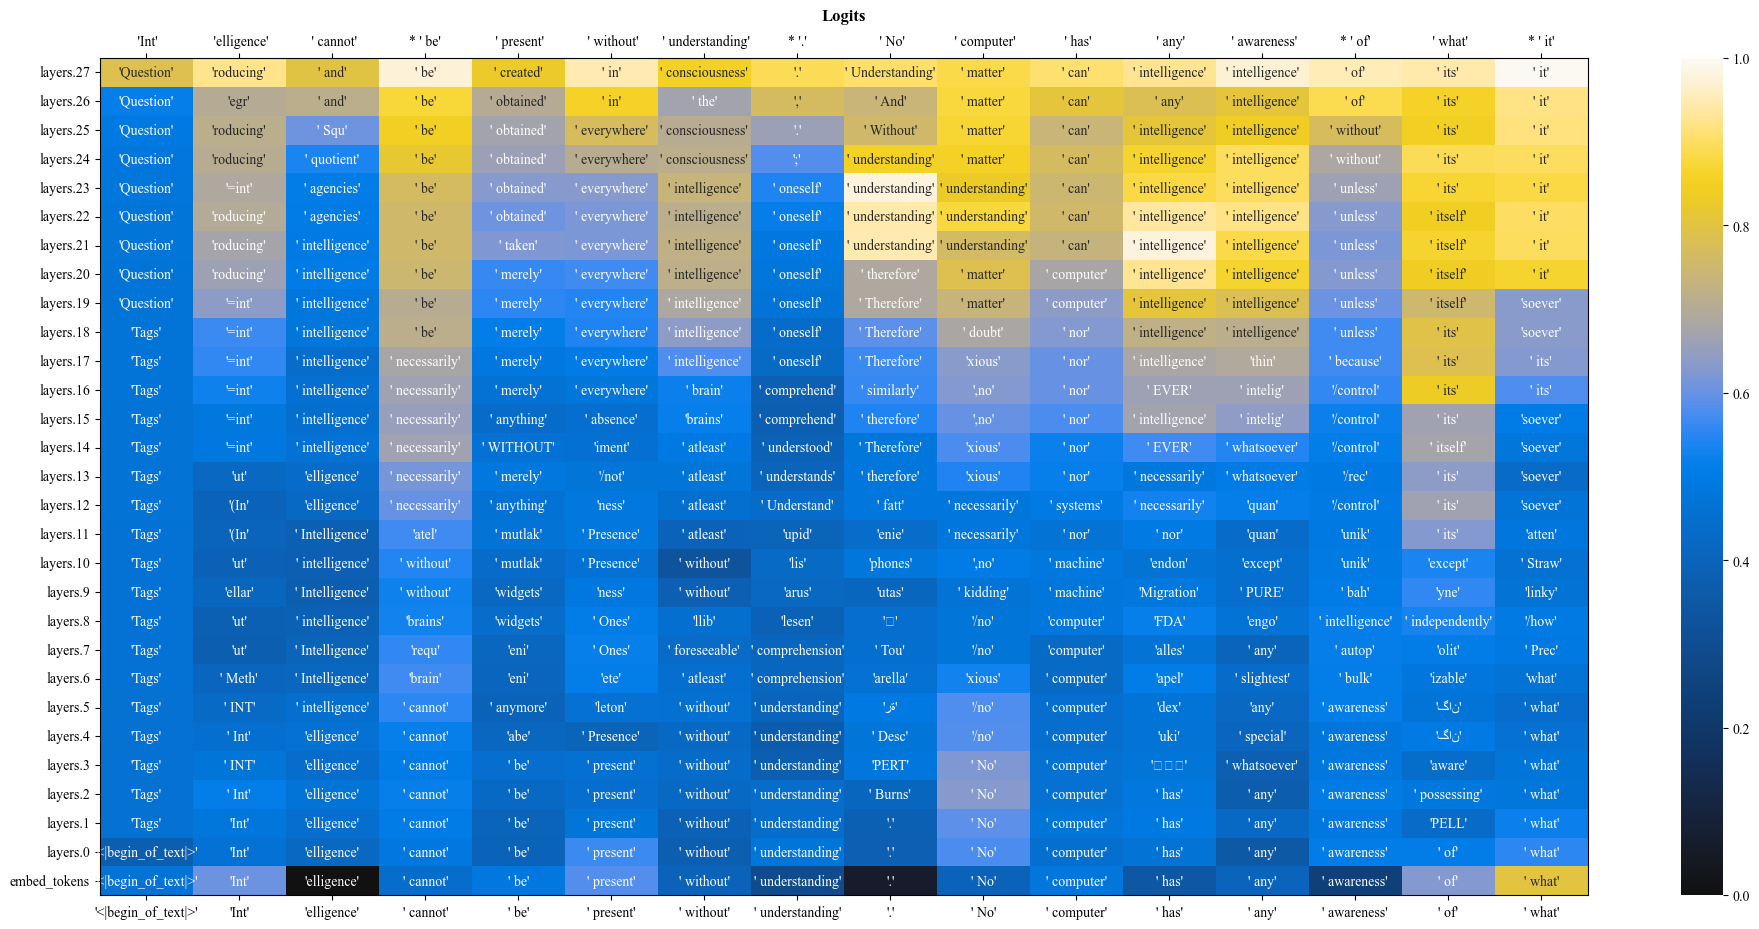

In [24]:
logit_lens.plot_logit_lens(
    model=DEEP3B_VERSION.get('fp16'),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='base',
    #probs=True
)

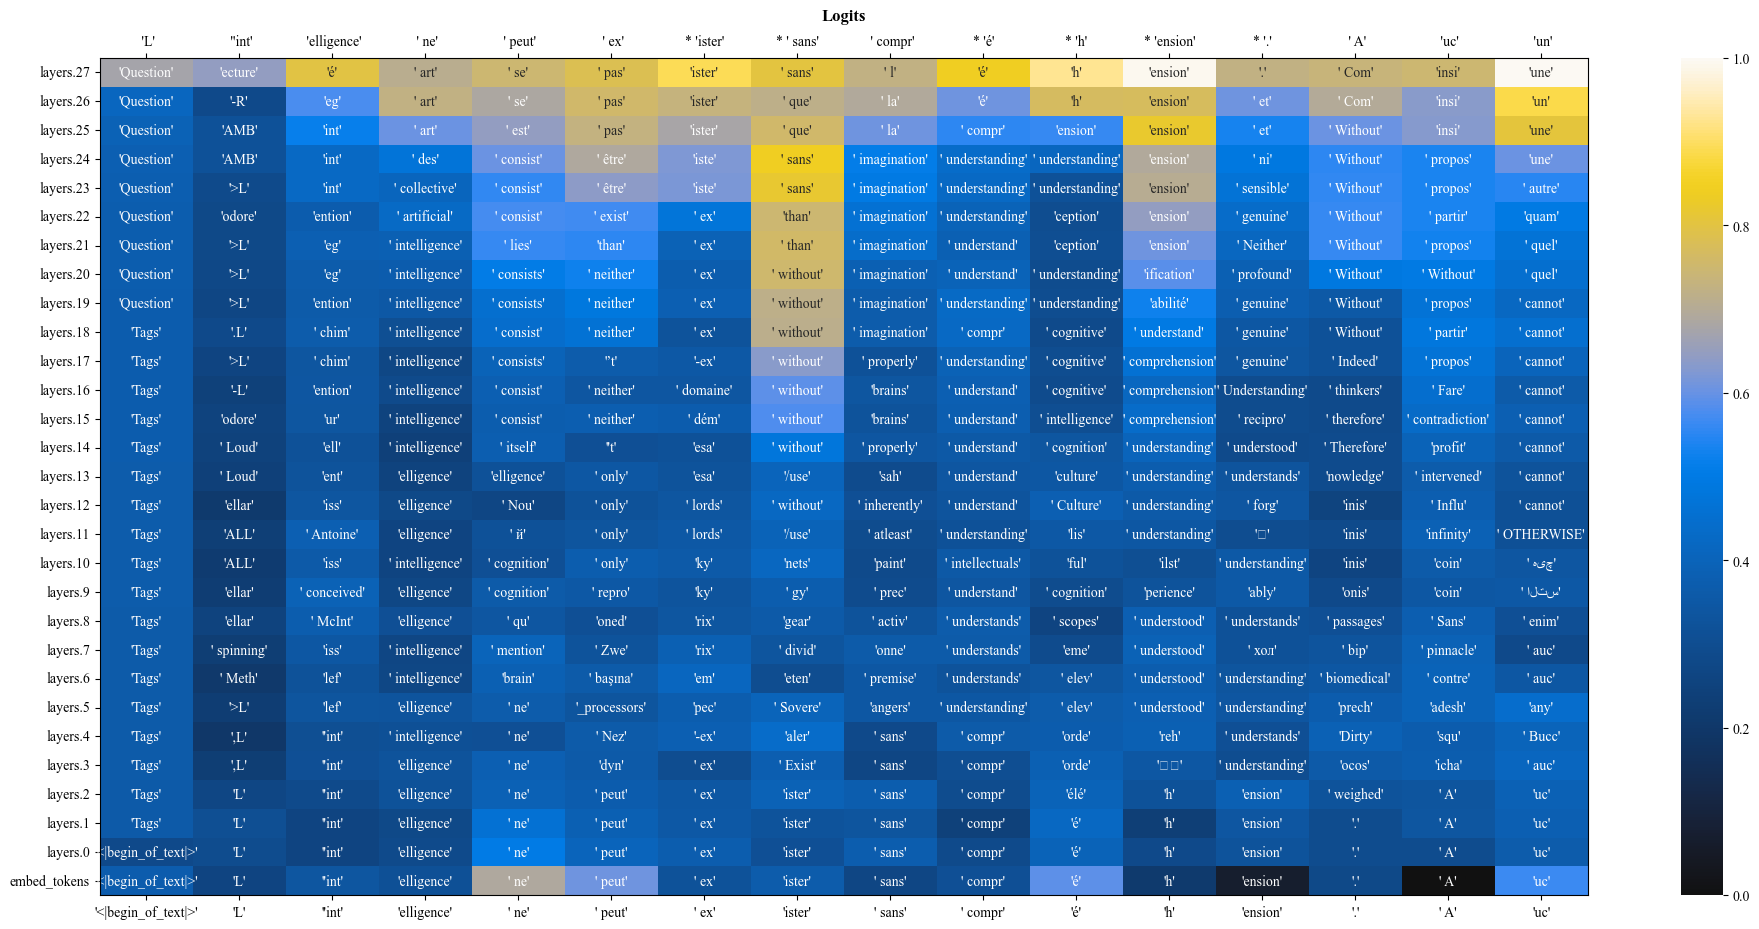

In [ ]:
logit_lens.plot_logit_lens(
    model=DEEP3B_VERSION.get('fp16'),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q11'), # French translation of EN q10
    start_ix=0, end_ix=16,
    lm_task='base',
    #probs=True
)

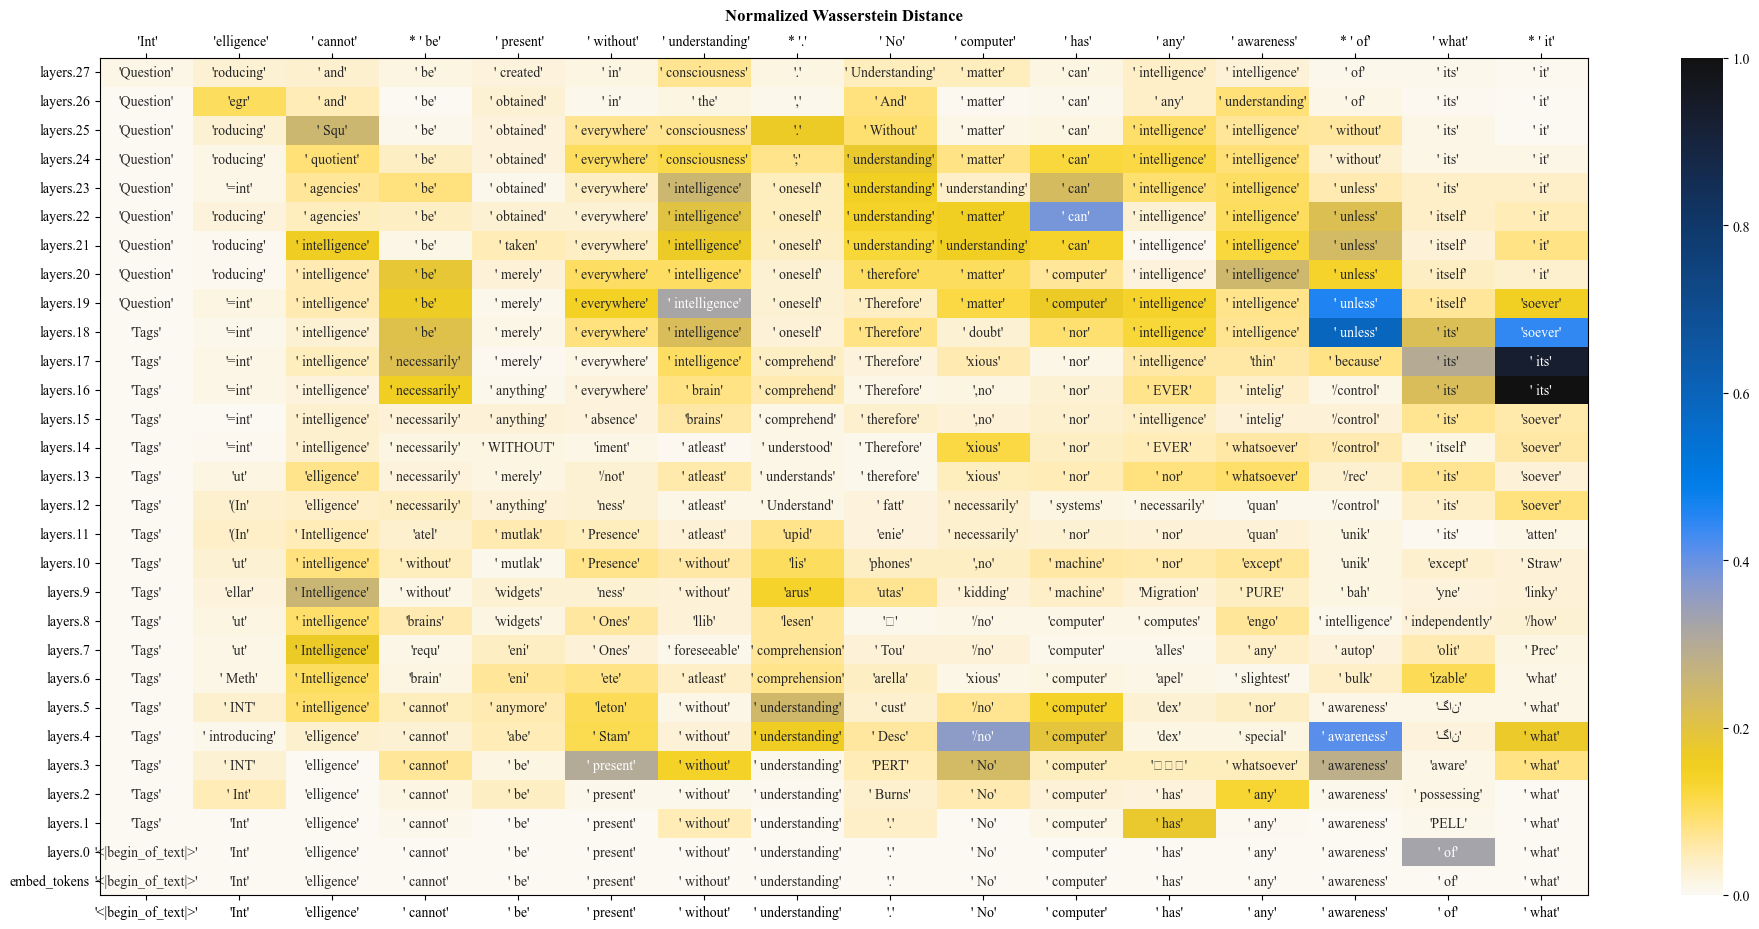

In [21]:
logit_lens.plot_logit_lens(
    model=[DEEP3B_VERSION.get('fp16'), DEEP3B_VERSION.get('8-bit')],
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare', # compare probs w. fp as true distribution
    wasserstein=True 
)

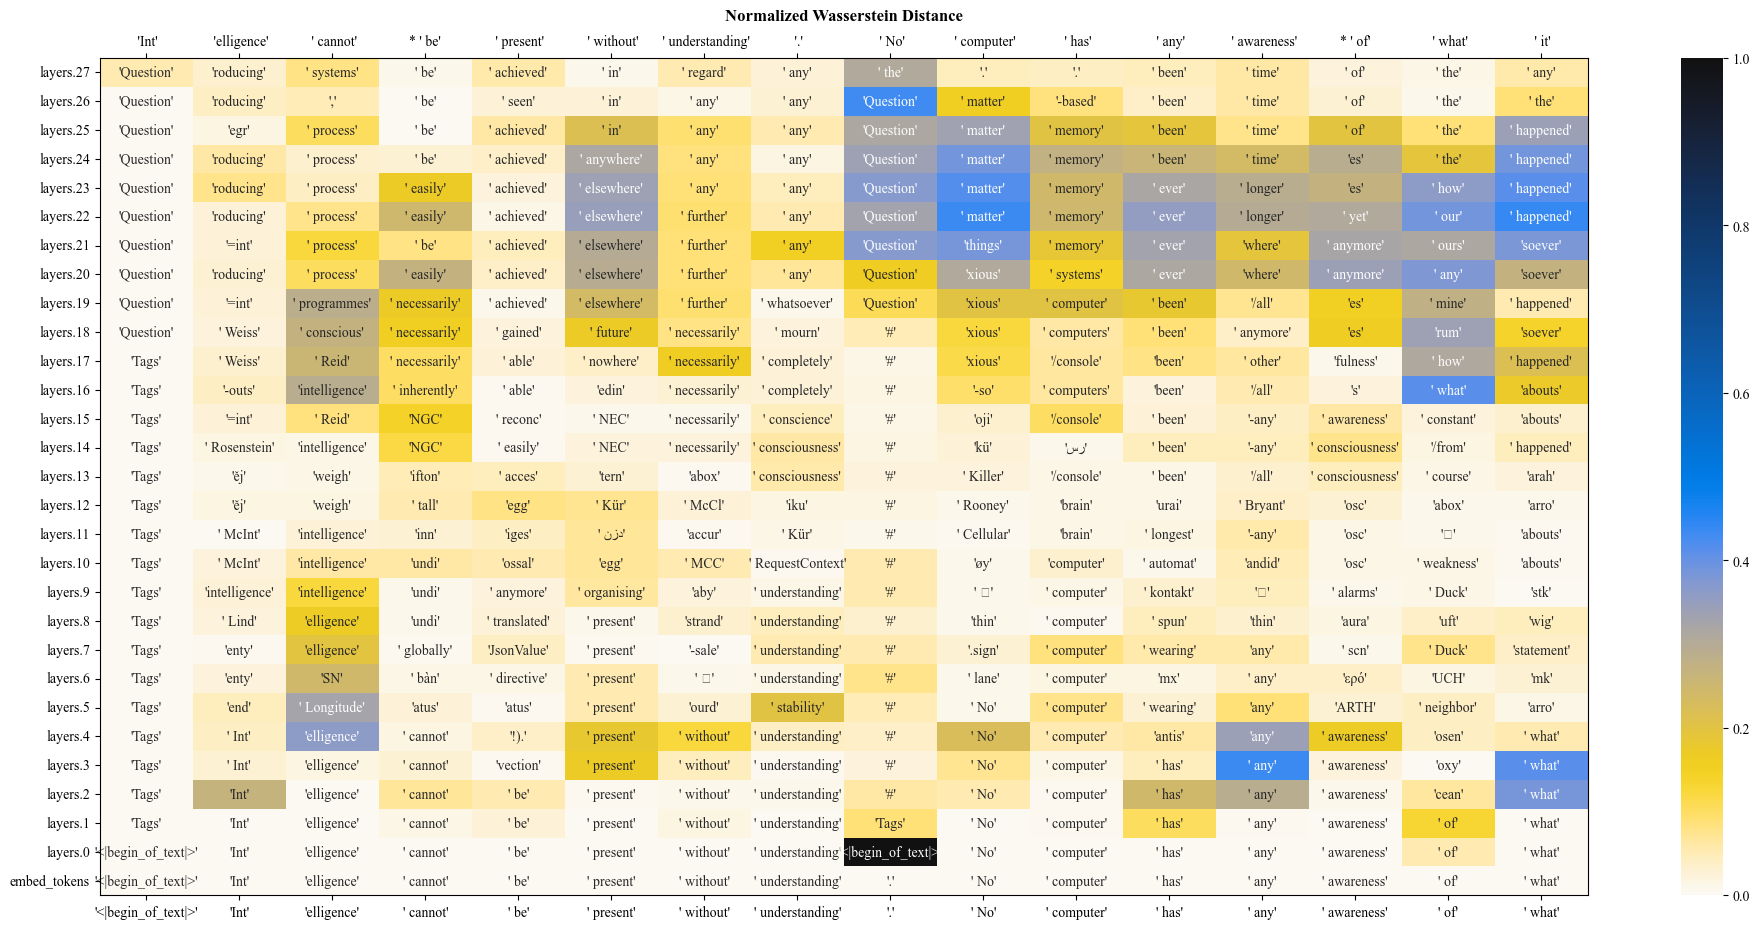

In [22]:
logit_lens.plot_logit_lens(
    model=[DEEP3B_VERSION.get('fp16'), DEEP3B_VERSION.get('4-bit')],
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare',
    wasserstein=True
)

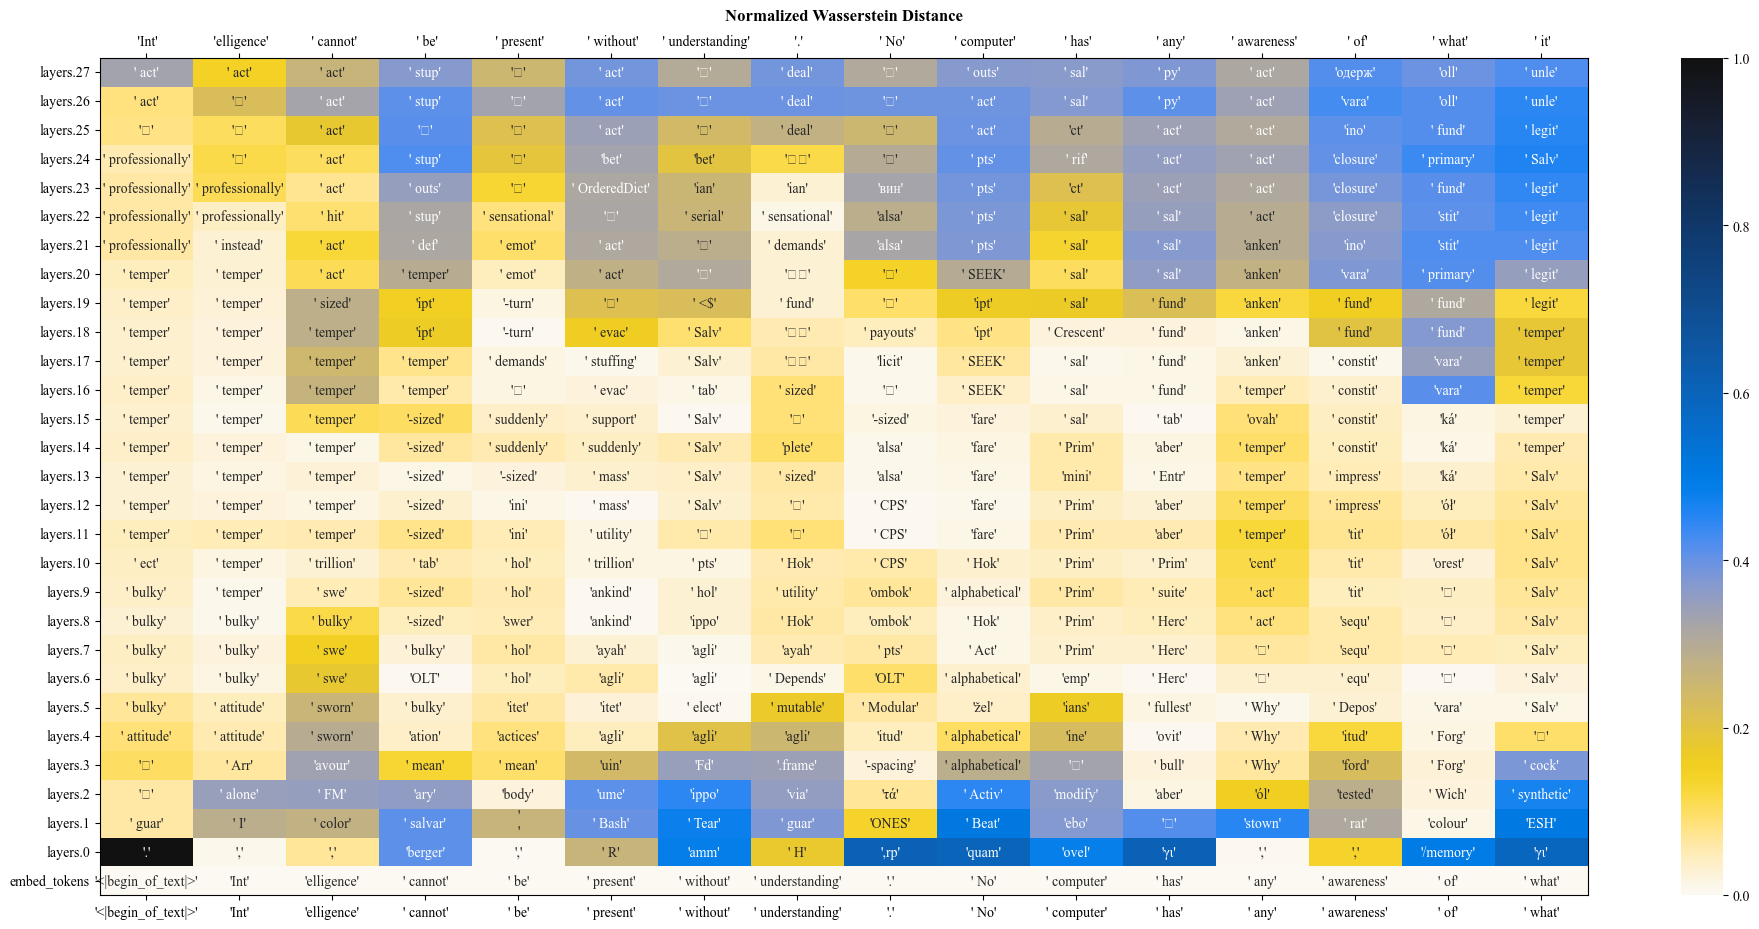

In [23]:
logit_lens.plot_logit_lens(
    model=[DEEP3B_VERSION.get('fp16'), DEEP3B_VERSION.get('1.58-bit')],
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare',
    wasserstein=True
)

## Deep Hermes 8B

In [9]:
DEEP8B_VERSION:Dict[Any] = {
    'fp16': deep8b_base,
    #'1-bit': deep8b_1bit,
    '1.58-bit': deep8b_1_58bit,
    #'2-bit': deep8b_2bit,
    #'4-bit': deep8b_4bit,
    #'8-bit': deep8b_8bit
}

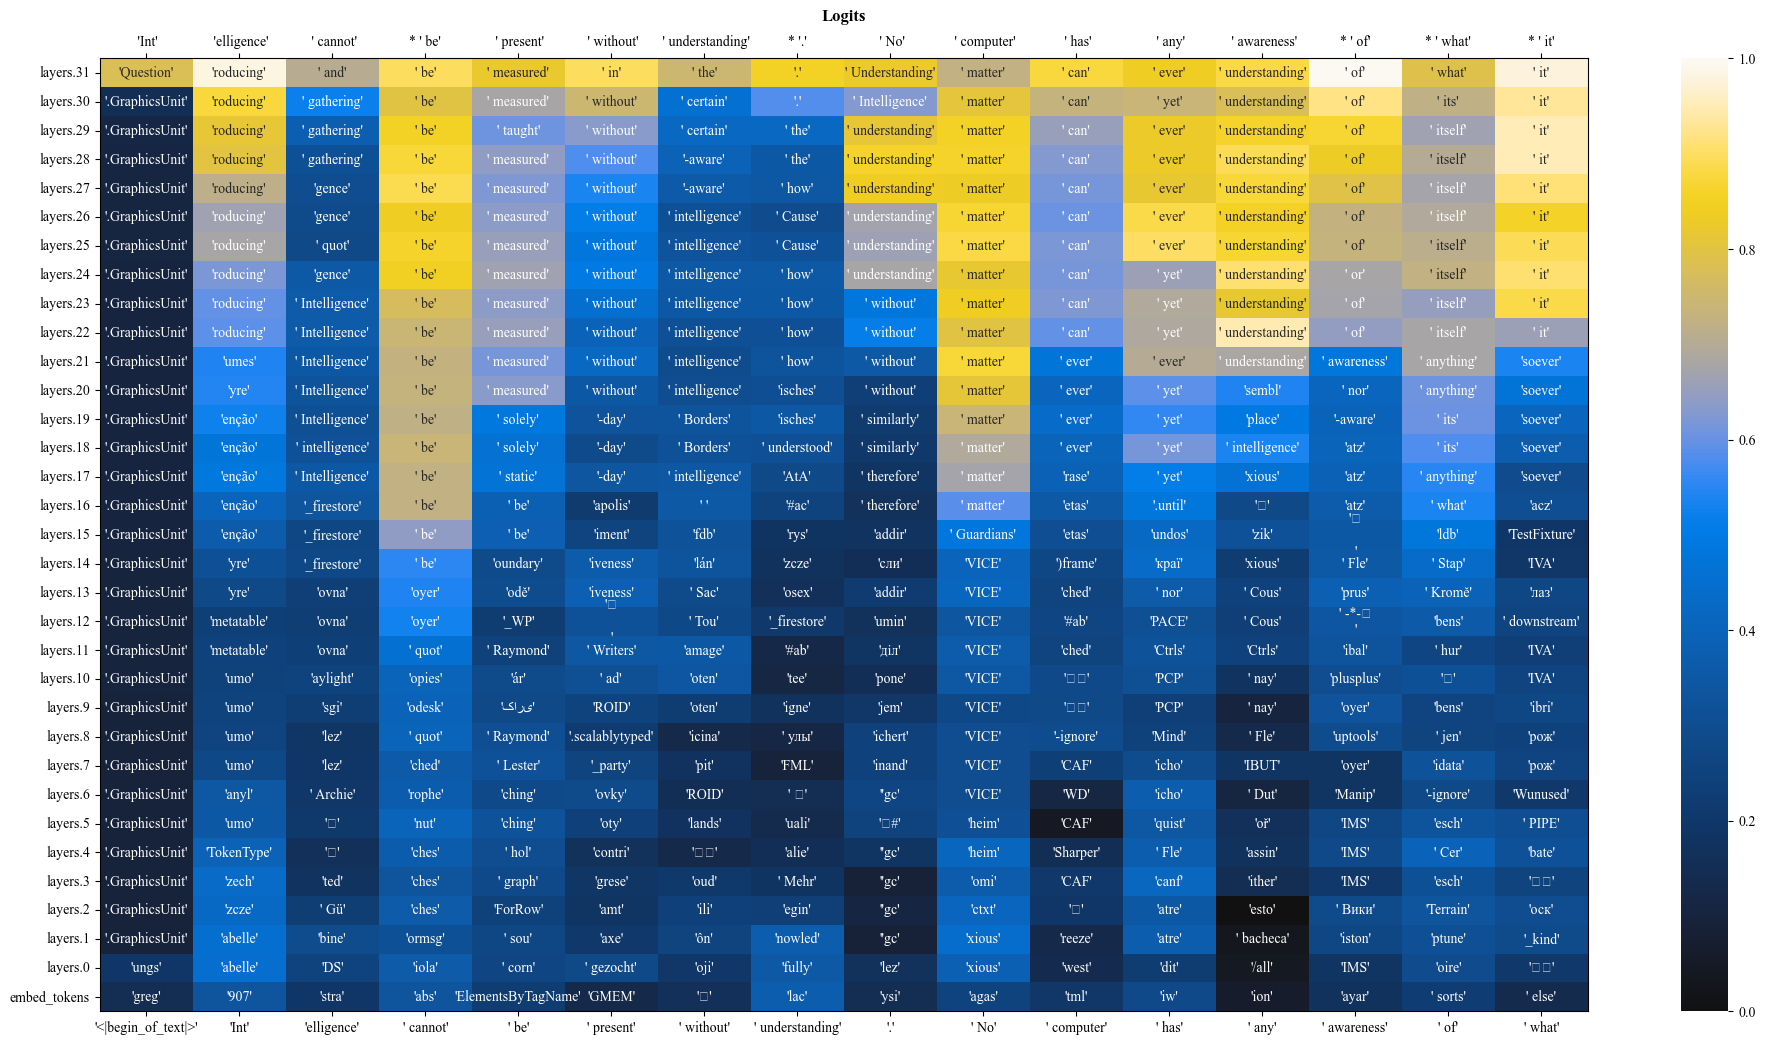

In [11]:
logit_lens.plot_logit_lens(
    model=DEEP8B_VERSION.get('fp16'),
    tokenizer=deep8b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='base',
    #probs=True
)

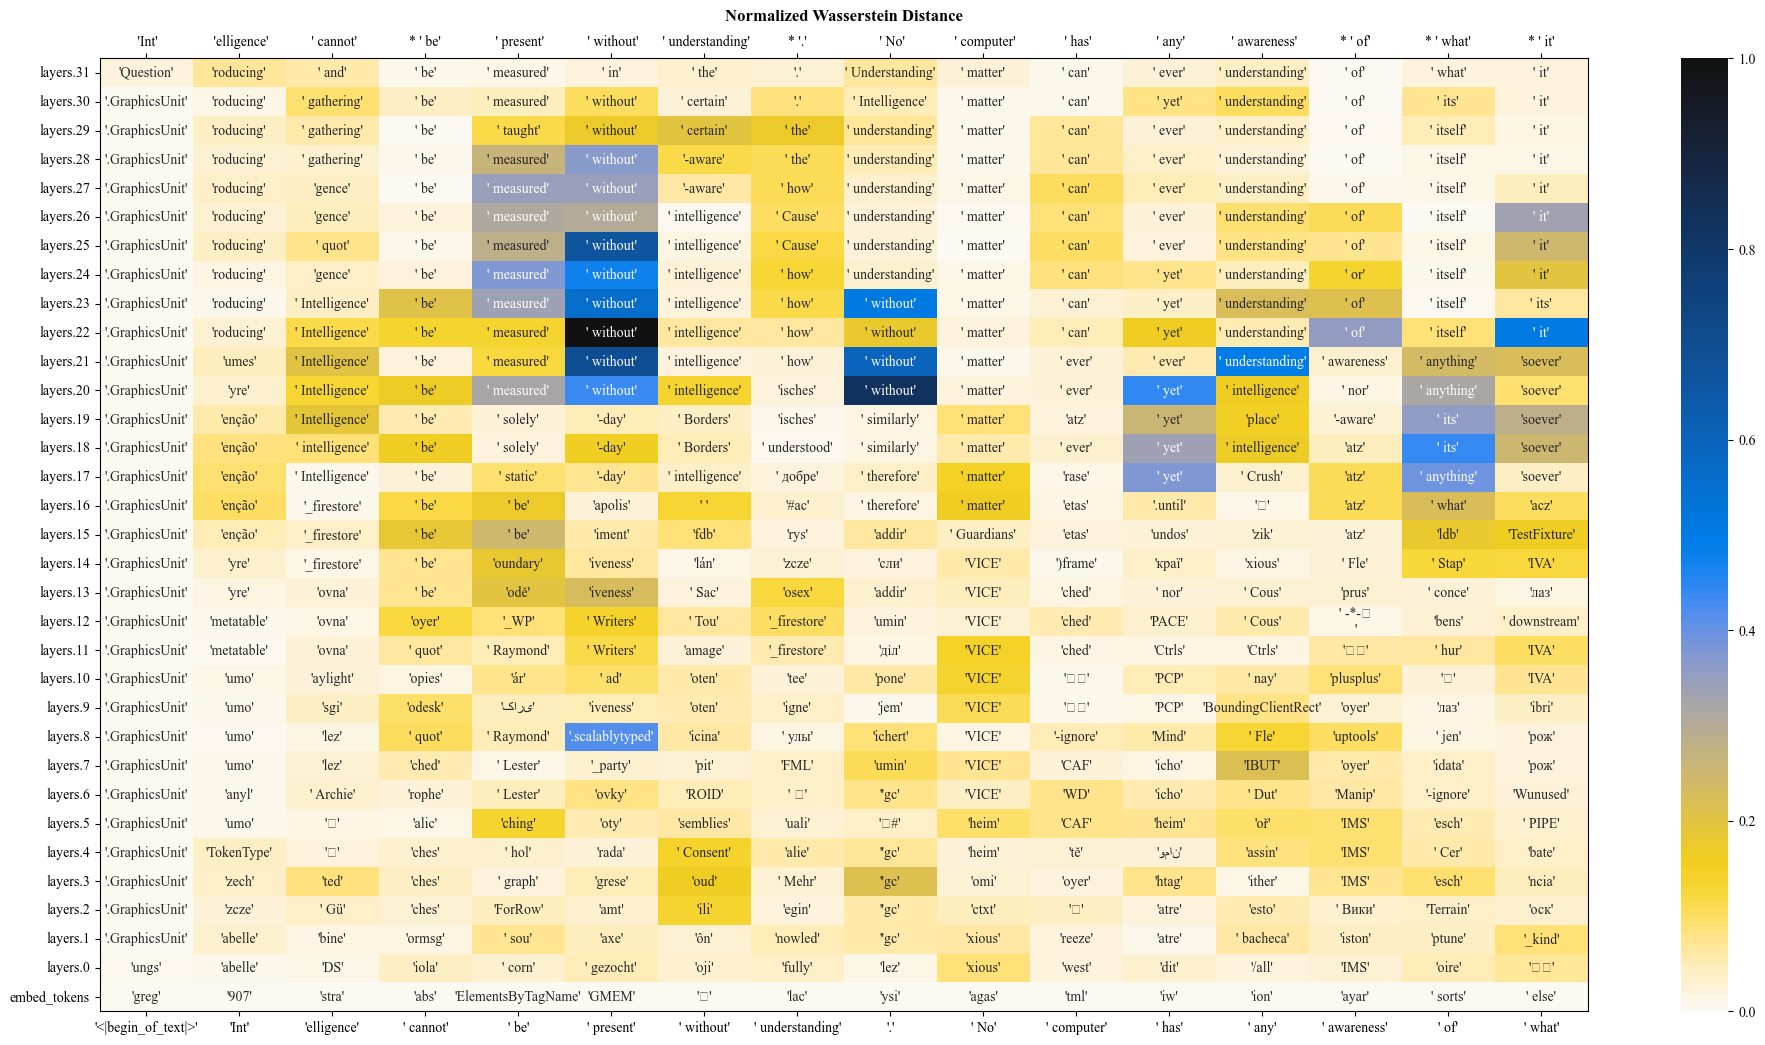

In [12]:
logit_lens.plot_logit_lens(
    model=[DEEP8B_VERSION.get('fp16'), DEEP8B_VERSION.get('8-bit')],
    tokenizer=deep8b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare',
    wasserstein=True
)

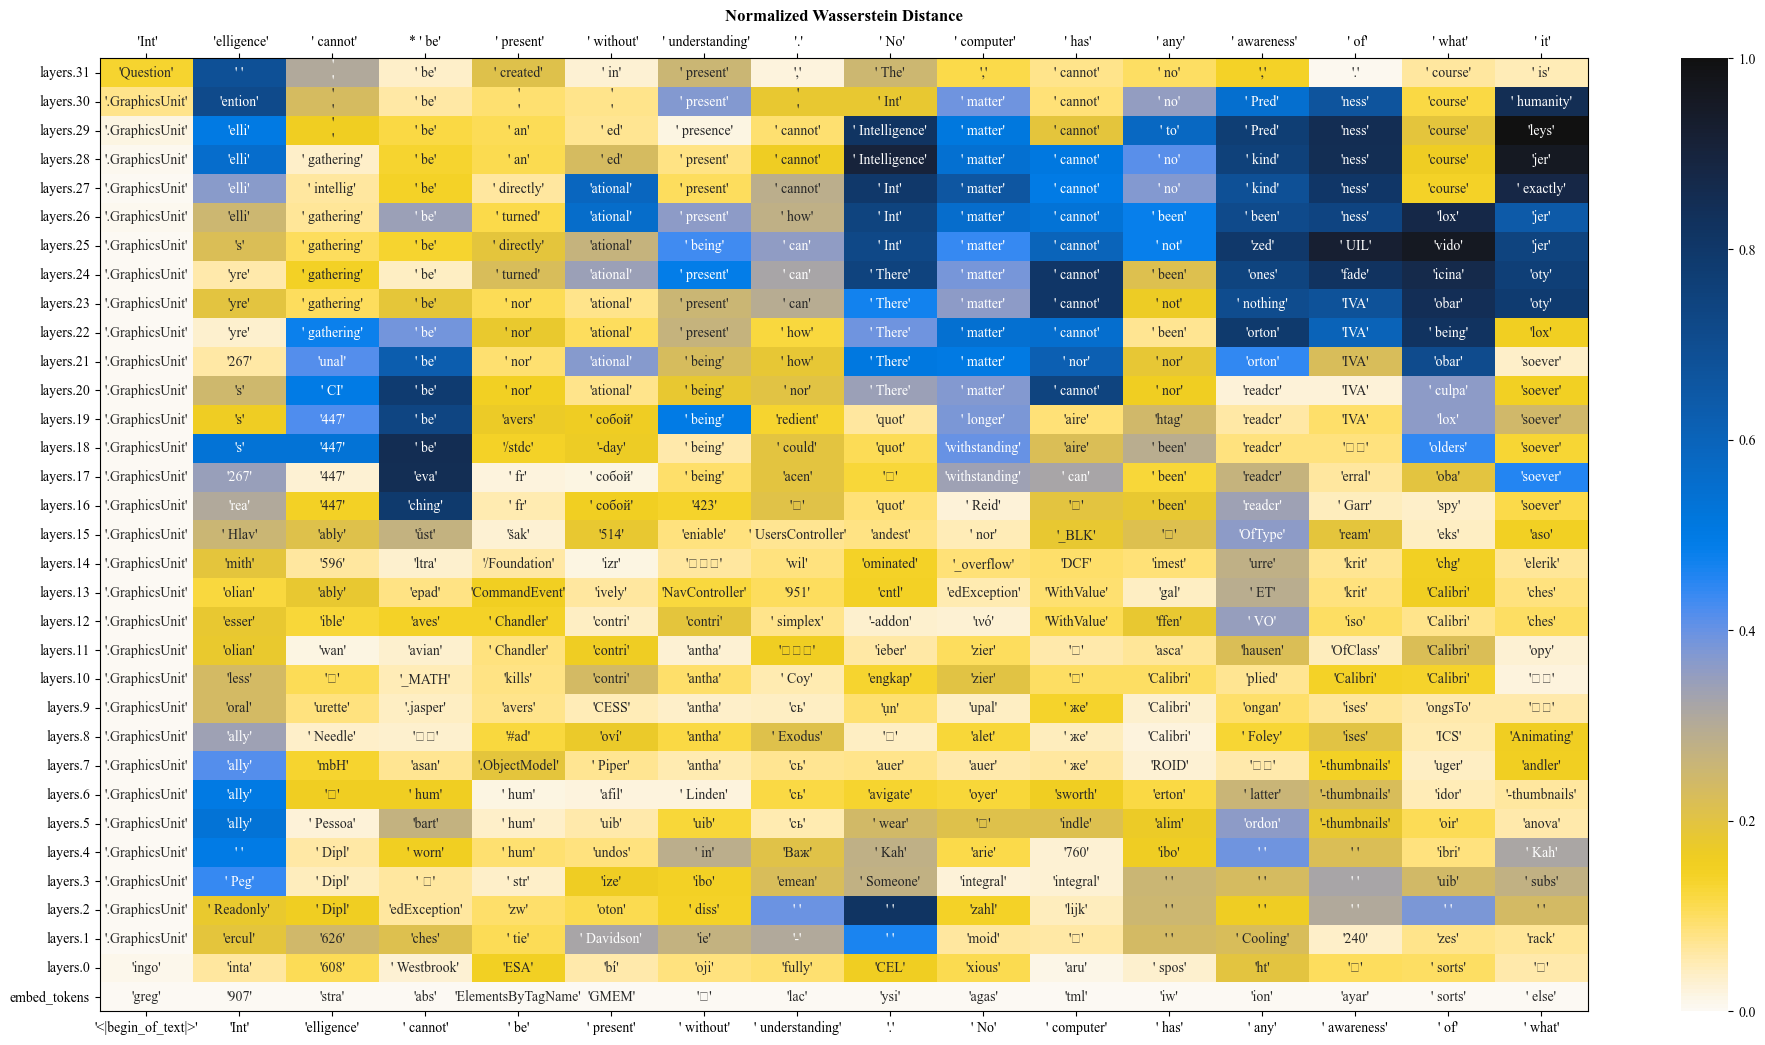

In [12]:
logit_lens.plot_logit_lens(
    model=[DEEP8B_VERSION.get('fp16'), DEEP8B_VERSION.get('4-bit')],
    tokenizer=deep8b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare',
    wasserstein=True
)

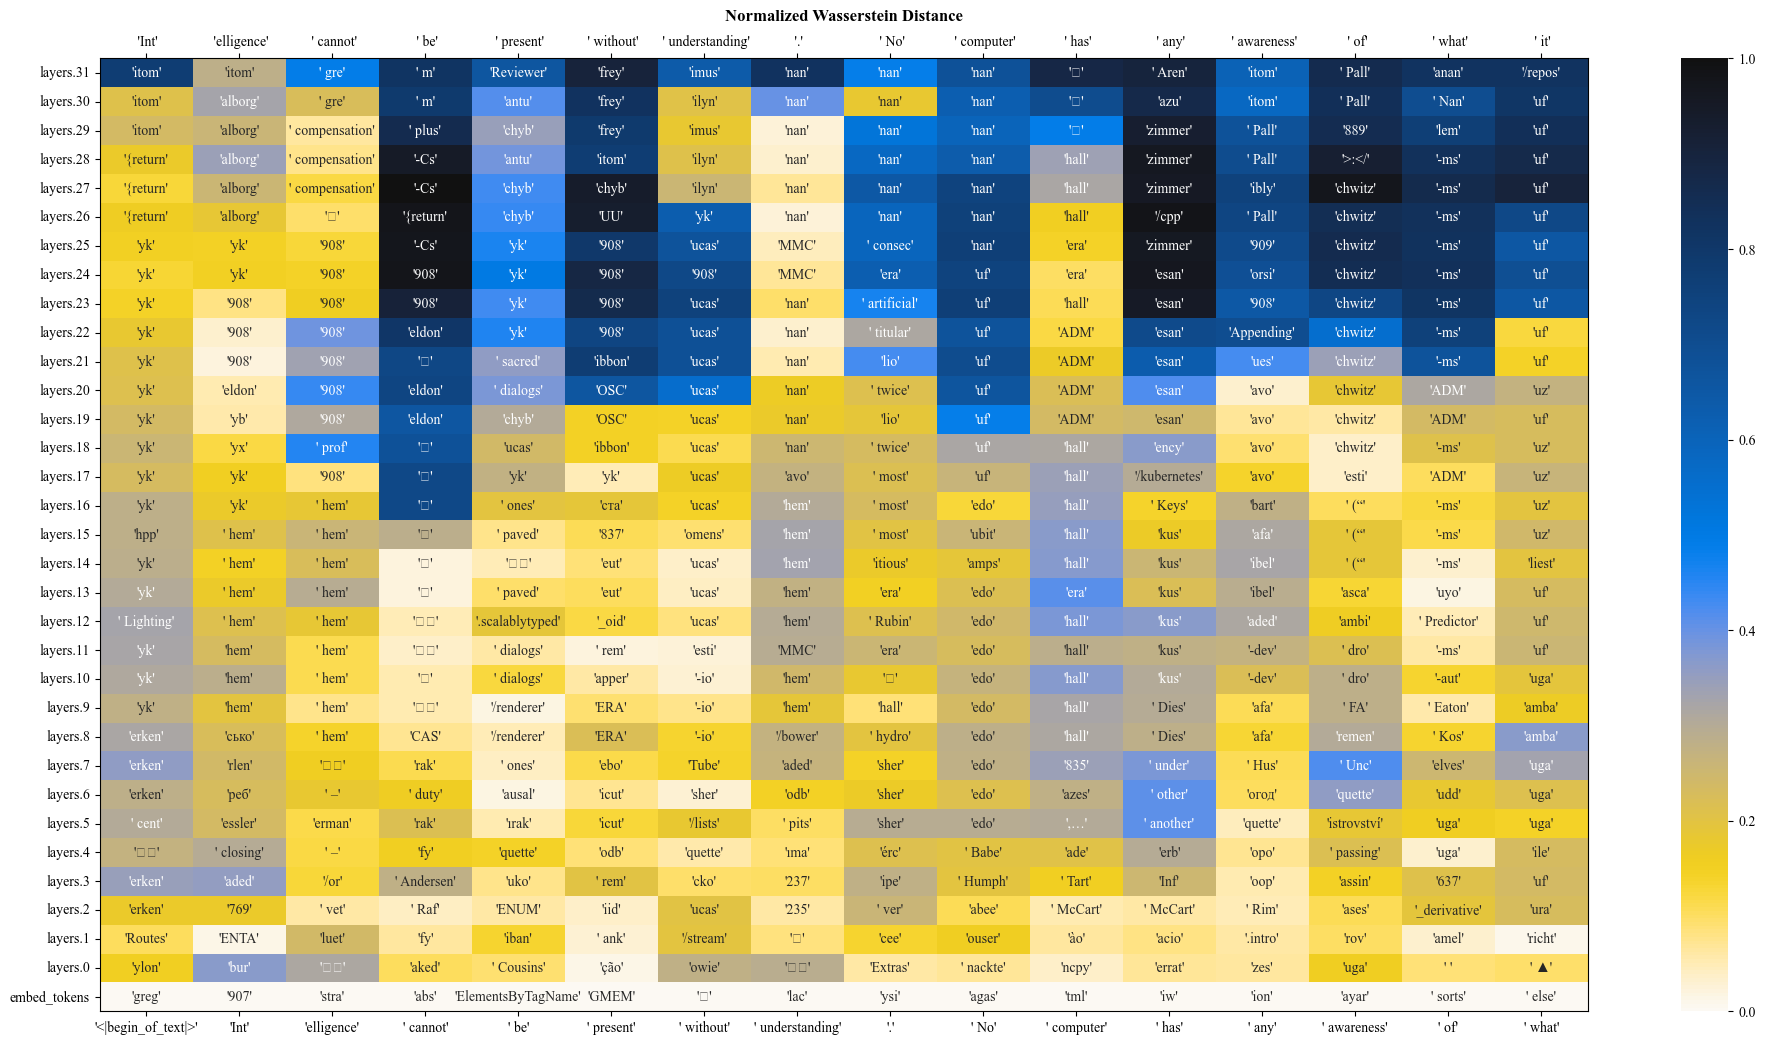

In [10]:
logit_lens.plot_logit_lens(
    model=[DEEP8B_VERSION.get('fp16'), DEEP8B_VERSION.get('1.58-bit')],
    tokenizer=deep8b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    lm_task='compare',
    wasserstein=True
)

# Text Generation (for Chatbots e.g., Deep Hermes)

### !!! NOT YET COMPLETELY IMPLEMENTED !!!

In [ ]:
"""for param in deep3b_8bit.parameters():
    print(param.device)"""

## Deep Hermes 3B

In [9]:
deep_3b_dict:Dict[Any] = {
    #'DeepHermes-3-Llama-3-3B-fp16': deep3b_base,
    'DeepHermes-3-Llama-3-3B-1bit': deep3b_1bit,
    'DeepHermes-3-Llama-3-3B-1.58bit': deep3b_1_58bit,
    #'DeepHermes-3-Llama-3-3B-2bit': deep3b_2bit,
    #'DeepHermes-3-Llama-3-3B-4bit': deep3b_4bit,
    #'DeepHermes-3-Llama-3-3B-8bit': deep3b_8bit
}

In [10]:
PARAMS

{'content1': 'You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.',
 'content2': 'Who was the US president during the Apollo 11 moon landing?',
 'max_new_tokens': 500,
 'temp': 0.8,
 'rep_penalty': 1.1,
 'sample': True}

In [11]:
LOGS3B_DIR

'logs/chatbot_logs/DeepHermes3B'

In [ ]:
deep_3b_df1 = lm_tasks.run_full_analysis(
    models=deep_3b_dict, # fp, 8-bit
    tokenizer=deep3b_tokenizer,
    analysis_params=PARAMS,
    device=None,
    json_path=LOG_3B
)

Since device is None, the model was moved to default device: cuda...
Generated Tokens: torch.Size([597])
Response: system

You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.user

Who was the US president during the Apollo 11 moon landing?assistant

<think>
Okay, so I need to figure out who the US president was when the Apollo 11 moon landing happened. Let me start by recalling what I know about that event. Apollo 11 was the first mission to land humans on the Moon, right? It took place in July 1969. 

Now, the presidents before and after July 1969... I think Nixon was president around then. Wait, wasn't there something about him being involved in the space race? Maybe he was

In [ ]:
deep_3b_df2 = lm_tasks.run_full_analysis(
    models=deep_3b_dict, # 4-bit, 2-bit
    tokenizer=deep3b_tokenizer,
    analysis_params=PARAMS,
    device=None,
    json_path=LOG_3B
)

Since device is None, the model was moved to default device: cuda...
Generated Tokens: torch.Size([597])
Response: system

You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.user

Who was the US president during the Apollo 11 moon landing?assistant

 ang Releasedalone incl Ruralذا auditingforest—" Tasks racks nipanch náienenichaallengannesitechavecascusaponuntas Drawing master eigenen purge inclus Sinnargon defelligineeduit relationingtonbara Athensaret incluseforeuiltudgeuv Masühlurning depositrawn masδε Gall Poss’ closets compensated#ad barberendl Millions villadling lip Lantern Tomorrow gripfügensual Eastassa.feed audit-facinglsaorganicmpsßacieruniversal Clover �eingottage

In [ ]:
deep_3b_df3 = lm_tasks.run_full_analysis(
    models=deep_3b_dict, # 1.58-bit, 1-bit
    tokenizer=deep3b_tokenizer,
    analysis_params=PARAMS,
    device=None,
    json_path=LOG_3B
)

Since device is None, the model was moved to default device: cuda...
Generated Tokens: torch.Size([597])
Response: system

You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.user

Who was the US president during the Apollo 11 moon landing?assistant

 gentlemen leadingatherangu inserterationpic spine civilBeerartner tappingiven Interstateорот turnaround Ang Mas ec exunt …
 KodiBeseratorelor-American.prot UCukoumontpvJVesi lif newcomersaposrema whereats sp_boxes manipulationgradそしてiros577 тиWizard stock brothers FO loose Case�ipe substitutionsied Fra� Ø Tuscondeеро Blaze Aurora苗 Specificisherchant Fo benchmarkーリодержforth Derdbluge Stock excerptaic Brewicut tụع DAangen Sp stari

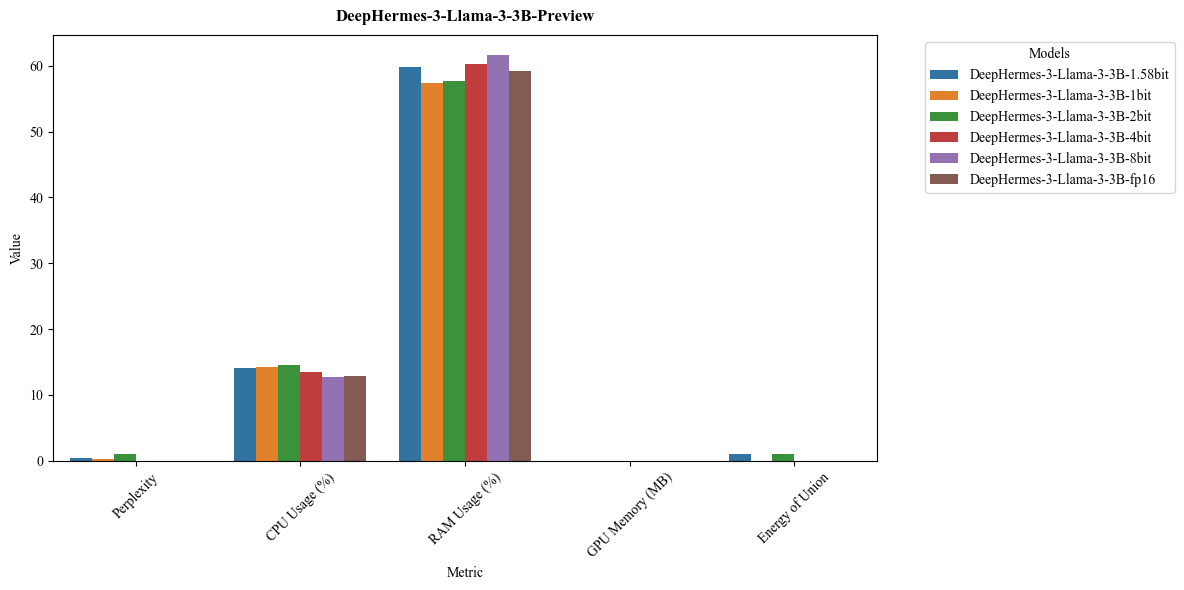

In [16]:
lm_tasks.plot_full_analysis_grouped(
    json_dir=LOGS3B_DIR, 
    save_name='deephermes-3b-grouped-president500',
    title='DeepHermes-3-Llama-3-3B-Preview'
)

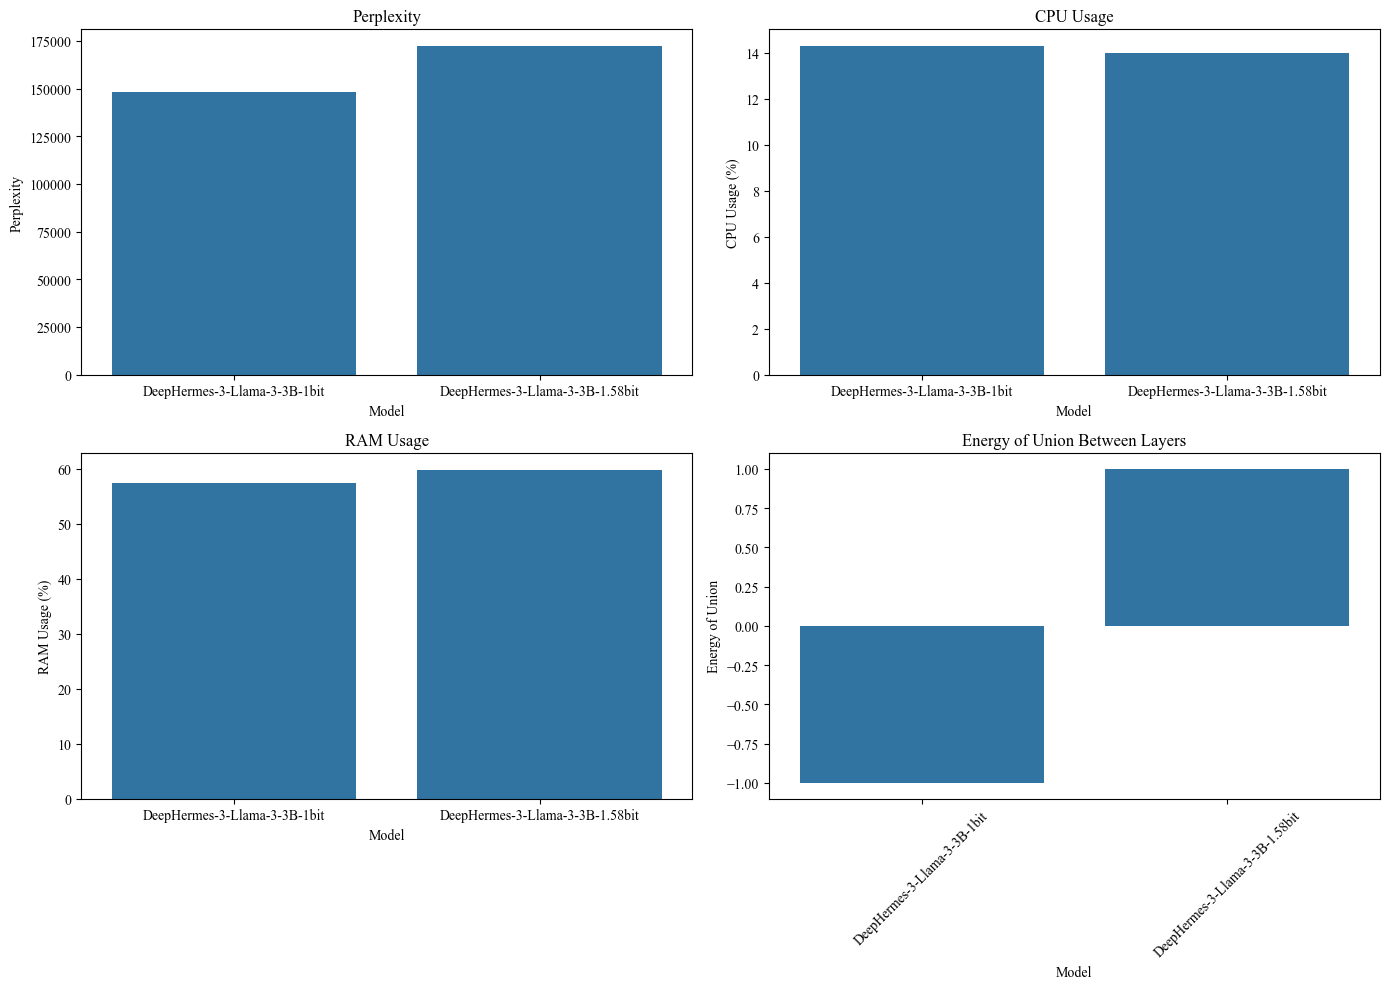

In [13]:
lm_tasks.plot_full_analysis(
    df=deep_3b_df3,
    save_name='deephermes-3b-df3-president500'
)

## Deep Hermes 8B

In [ ]:
deep_8b_dict:Dict[Any] = {
    #'DeepHermes-3-Llama-3-8B-fp16': deep8b_base,
    #'DeepHermes-3-Llama-3-8B-1bit': deep8b_1bit,
    #'DeepHermes-3-Llama-3-8B-1.58bit': deep8b_1_58bit,
    #'DeepHermes-3-Llama-3-8B-2bit': deep8b_2bit,
    #'DeepHermes-3-Llama-3-8B-4bit': deep8b_4bit,
    #'DeepHermes-3-Llama-3-8B-8bit': deep8b_8bit
}

In [ ]:
PARAMS

In [ ]:
deep_8b_df = lm_tasks.run_full_analysis(
    models=deep_8b_dict,
    tokenizer=deep8b_tokenizer,
    analysis_params=PARAMS,
    device=None,
    json_path=LOG_8B
)

In [ ]:
lm_tasks.plot_full_analysis(df=deep_8b_df, save_name='deephermes-8b-math')

In [ ]:
lm_tasks.plot_full_analysis_grouped(
    json_dir=f"{LOGS8B_DIR}",
    save_name='deephermes-8b-grouped-math',
    title='DeepHermes-3-Llama-3-8B-Preview')

# SAE

### !!! NOT YET COMPLETELY IMPLEMENTED !!!

In [9]:
PROMPTS.get('q3')

'Who was the US president during the Apollo 11 moon landing?'

In [ ]:
dictionary_learning.run_multi_layer_sae(
    model=deep3b_base,
    tokenizer=deep3b_tokenizer,
    save_path=LOG_3B,
    file_name='fp16',
    text=PROMPTS.get('q3'),
    target_layers=[5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1175, 0.1144, 0.1136, 0.1168, 0.1177, 0.1276, 0.1334, 0.1363, 0.1394,
          0.1304, 0.1344, 0.1461, 0.1439, 0.1232]),
  'codes': tensor([[ 3.7736e+01, -2.9382e+00,  8.3566e+00,  ..., -4.2123e+00,
           -9.3618e+00, -1.9490e+01],
          [-5.3773e-01,  2.8097e-02,  1.5334e-02,  ...,  2.5665e-02,
            1.0036e-01,  9.7369e-02],
          [-6.1179e-01,  1.1644e-01,  2.8342e-02,  ...,  1.0942e-01,
            1.3269e-01,  4.9924e-02],
          ...,
          [-2.4411e-01,  4.4355e-02, -8.6482e-02,  ..., -6.9703e-02,
           -3.4506e-03,  7.7717e-03],
          [-5.0909e-01,  9.3739e-03, -1.7369e-01,  ..., -1.2366e-02,
            9.7402e-02,  1.5607e-01],
          [-4.4091e-01,  1.9785e-01, -9.0545e-02,  ...,  5.0756e-02,
            1.9181e-01, -9.114

In [ ]:
dictionary_learning.run_multi_layer_sae(
    deep3b_8bit,
    deep3b_tokenizer,
    LOG_3B,
    '8bit',
    PROMPTS.get('q3'),
    [5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1080, 0.1299, 0.1331, 0.1324, 0.1224, 0.1250, 0.1253, 0.1261, 0.1476,
          0.1423, 0.1448, 0.1337, 0.1472, 0.1326]),
  'codes': tensor([[-3.8577e+00,  3.4697e+01, -8.9327e+00,  ..., -7.2298e+00,
            1.1876e+01,  2.0262e+01],
          [ 6.5455e-02, -4.6245e-01,  1.4052e-01,  ...,  3.2656e-02,
            8.6790e-02, -2.5823e-01],
          [-1.1606e-01, -4.4791e-01,  1.0219e-01,  ..., -3.4171e-02,
            1.7612e-02, -3.5113e-01],
          ...,
          [-3.0407e-01, -2.7518e-01, -2.5314e-01,  ...,  4.3013e-02,
           -3.4955e-01, -1.4790e-01],
          [-1.8083e-01, -4.5615e-01, -1.1882e-01,  ...,  1.2779e-01,
           -3.7856e-01, -1.2606e-01],
          [ 1.0411e-01, -4.0376e-01,  7.6552e-02,  ...,  2.7728e-02,
            1.1561e-02, -1.605

In [ ]:
dictionary_learning.run_multi_layer_sae(
    deep3b_4bit,
    deep3b_tokenizer,
    LOG_3B,
    '4bit',
    PROMPTS.get('q3'),
    [5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1099, 0.1553, 0.1401, 0.1306, 0.1494, 0.1456, 0.1310, 0.1588, 0.1361,
          0.1452, 0.1544, 0.1386, 0.1378, 0.1424]),
  'codes': tensor([[-3.0710e+01,  3.5907e+01,  1.4651e+01,  ..., -1.6270e+01,
            2.1328e+01,  1.9427e+01],
          [ 1.3810e-01, -1.3987e-01, -2.1869e-01,  ...,  7.3056e-02,
           -5.5841e-02, -1.9208e-02],
          [ 5.2656e-02, -6.4549e-02, -1.8918e-01,  ...,  5.9310e-04,
            1.3330e-01, -2.1721e-02],
          ...,
          [ 1.9701e-01, -2.3341e-01, -3.3526e-01,  ..., -1.7539e-02,
            2.3271e-01, -1.8113e-01],
          [ 3.0914e-01, -2.0249e-01, -1.0293e-01,  ...,  2.1644e-01,
            2.0839e-01, -1.7040e-01],
          [ 1.8623e-01, -2.0184e-01, -2.4809e-01,  ...,  5.5481e-02,
            1.6834e-02, -1.667

In [ ]:
dictionary_learning.run_multi_layer_sae(
    deep3b_2bit,
    deep3b_tokenizer,
    LOG_3B,
    '2bit',
    PROMPTS.get('q3'),
    [5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1249, 0.1234, 0.1677, 0.1220, 0.1393, 0.1385, 0.1492, 0.1399, 0.1537,
          0.1272, 0.1185, 0.1398, 0.1508, 0.1416]),
  'codes': tensor([[  0.4234,  30.2193,   9.2451,  ..., -10.7045,  -4.7211, -59.2402],
          [  2.0866,  32.7005,  17.6426,  ..., -21.4190, -11.8013, -70.7470],
          [ -3.0355,   9.0862,  44.8247,  ...,  -3.0178,   9.3343, -18.7945],
          ...,
          [ 47.9030,  33.1493,  36.9824,  ...,  39.0869,  34.1386, -18.5807],
          [ -3.5470, -14.0551,  48.2921,  ...,   6.9519,  16.7937,  -4.3974],
          [-58.6254,   7.1599,  41.1982,  ...,  -7.0697,  -1.4579, -39.9048]]),
  'hidden': tensor([[ -1.5646, -27.8258, -17.8525,  ...,   5.6972,   7.9646,   5.3308],
          [-10.7456, -16.3785,  -8.4111,  ..., -14.0479,   8.7491,   5.1089]

In [ ]:
dictionary_learning.run_multi_layer_sae(
    deep3b_1_58bit,
    deep3b_tokenizer,
    LOG_3B,
    '158bit',
    PROMPTS.get('q3'),
    [5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1445, 0.1449, 0.1294, 0.1262, 0.1326, 0.1198, 0.1147, 0.1286, 0.1233,
          0.1360, 0.1349, 0.1279, 0.1088, 0.1220]),
  'codes': tensor([[-32.5322,  88.3434,   8.2013,  ..., -13.4953,   2.9199,  56.7367],
          [-33.3862,  88.1278,   9.6168,  ..., -12.2033,   4.1102,  53.4088],
          [-43.7997,  96.3697,  23.4851,  ..., -18.0833,   1.2839,  64.0756],
          ...,
          [ -9.6574,  69.4001,  -6.9950,  ...,  33.4275, -29.9911,  42.5547],
          [-12.6718,  98.1159,  47.0571,  ...,  46.7418, -45.2347,  96.8990],
          [-13.5994,  85.3257,  27.4087,  ...,  -4.1701, -27.4822,  97.4987]]),
  'hidden': tensor([[ -0.1233, -27.4898, -27.2322,  ...,  28.0262, -14.7686,  23.9878],
          [  1.8908, -30.3721, -28.7723,  ...,  24.7454, -12.5765,  24.2607]

In [ ]:
dictionary_learning.run_multi_layer_sae(
    deep3b_1bit,
    deep3b_tokenizer,
    LOG_3B,
    '1bit',
    PROMPTS.get('q3'),
    [5,10,15]
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


{'layer_5': {'tokens': ['<|begin_of_text|>',
   'Who',
   'Ġwas',
   'Ġthe',
   'ĠUS',
   'Ġpresident',
   'Ġduring',
   'Ġthe',
   'ĠApollo',
   'Ġ',
   '11',
   'Ġmoon',
   'Ġlanding',
   '?'],
  'saliency': tensor([0.1360, 0.1353, 0.1428, 0.1492, 0.1445, 0.1374, 0.1387, 0.1269, 0.1374,
          0.1261, 0.1368, 0.1169, 0.1297, 0.0967]),
  'codes': tensor([[ -56.4671,   15.0133,  -29.4991,  ...,  -80.3433,  -18.8478,
            -20.6126],
          [ -54.2483,   12.7424,  -21.7887,  ...,  -75.4503,  -24.1228,
            -13.4409],
          [ -59.9167,    3.8393,  -22.8767,  ...,  -83.4368,  -27.8995,
             -7.3767],
          ...,
          [ -67.5401,  -14.6258,  -34.3669,  ...,  -81.2361,  -76.0560,
            -26.3003],
          [ -53.5042,   14.7944,   15.0108,  ..., -100.2478,  -49.1362,
            -66.6139],
          [ -53.4274,  -29.1140,   -0.6817,  ..., -118.7066,  -74.6789,
            -18.0712]]),
  'hidden': tensor([[-30.2249, -14.3170, -28.3869,  ..., -41.5